In [1]:
import pandas as pd
import numpy as np
import arviz as az
import graphviz as gz
import matplotlib.pyplot as plt
import pymc as pm
import seaborn as sns
from scipy.special import expit as logistic
from patsy import dmatrix

sns.set()
az.style.use("arviz-darkgrid")

RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)

In [2]:
data_path = 'data/processed_data.csv'

In [3]:
data = pd.read_csv(data_path)

/var/folders/5l/01f91zmj7mq1k2wrl_k7z2740000gn/T/ipykernel_11704/560202589.py:1: DtypeWarning: Columns (579,629,630,631,664,665,666,667,668,669,670,684,685,686,687,688,714) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_path)


In [4]:
data.head()

,Unnamed: 0,CCAA,TMUNI,IDENTHOGAR,NORDEN,SEXO,EDAD,INFOR_DISC,INFOR_HOG,INFOR_RELAC,...,B_15_3,B_15_4,B_15_5,B_15_6,B_15_7,B_15_8,B_15_9,B_15_10,B_16,FACTOR
0,1,16,4,7,1,1,56,1,,,...,,,,,,,,,,222.916
1,2,16,4,10,2,1,67,1,,,...,,,,,,,,,,296.805
2,3,16,5,21,1,2,52,1,,,...,,,,,,,,,,300.734
3,4,16,5,24,3,1,37,6,1,3,...,,,,,,,,,,326.648
4,5,16,5,30,4,1,56,1,,,...,,,,,,,,,,324.750


In [5]:
relevant_columns = ['SEXO', 'EDAD', 'H_14']

In [6]:
data = data[relevant_columns]

In [7]:
data = data.rename(columns={'SEXO': 'sex', 'EDAD': 'age', 'H_14': 'discrimination'})

In [8]:
data['sex'] -= 1

In [9]:
data.head()

,sex,age,discrimination
0,0,56,1
1,0,67,1
2,1,52,1
3,0,37,1
4,0,56,2


In [10]:
data.discrimination.unique()

array([1, 2, 9, 3, 4])

In [11]:
data = data.query('discrimination != 9')

In [12]:
data['discrimination_n'] = data.discrimination / data.discrimination.max()

In [41]:
data['age_n'] = data.age / data.age.max()

In [19]:
data = data.astype(float)

In [20]:
data.sort_values(by='age', inplace=True)

### Linear Regression, Gaussian Likelihood

In [90]:
with pm.Model() as model:
    
    # Uninformative Priors
    alpha = pm.Normal('alpha', mu=0, sigma=1, shape=2)
    beta = pm.Normal('beta', mu=0, sigma=1, shape=2)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # IDs
    sex_id = pm.intX(pm.ConstantData('sex_id', data['sex']))

    # Expected value of outcome
    mu = alpha[sex_id] + beta[sex_id]*data['age']/data.age.max()
    # Likelihood
    discrimination = pm.Normal('discrimination', mu=mu, sigma=sigma, observed=data['discrimination_n'])

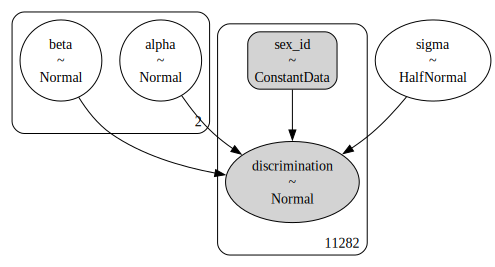

In [91]:
pm.model_to_graphviz(model)

In [92]:
with model:
    prior = pm.sample_prior_predictive(samples=1000, random_seed=rng)

Sampling: [alpha, beta, discrimination, sigma]


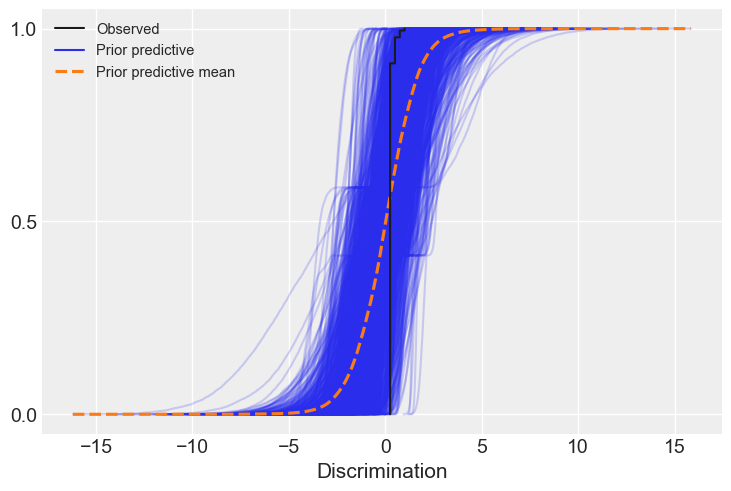

In [93]:
az.plot_ppc(prior, group='prior', kind='cumulative')
plt.xlabel('Discrimination')
plt.show()

In [94]:
with model:
    # draw 1000 posterior samples
    idata = pm.sample(random_seed=rng)
    pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=rng)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
Sampling: [discrimination]


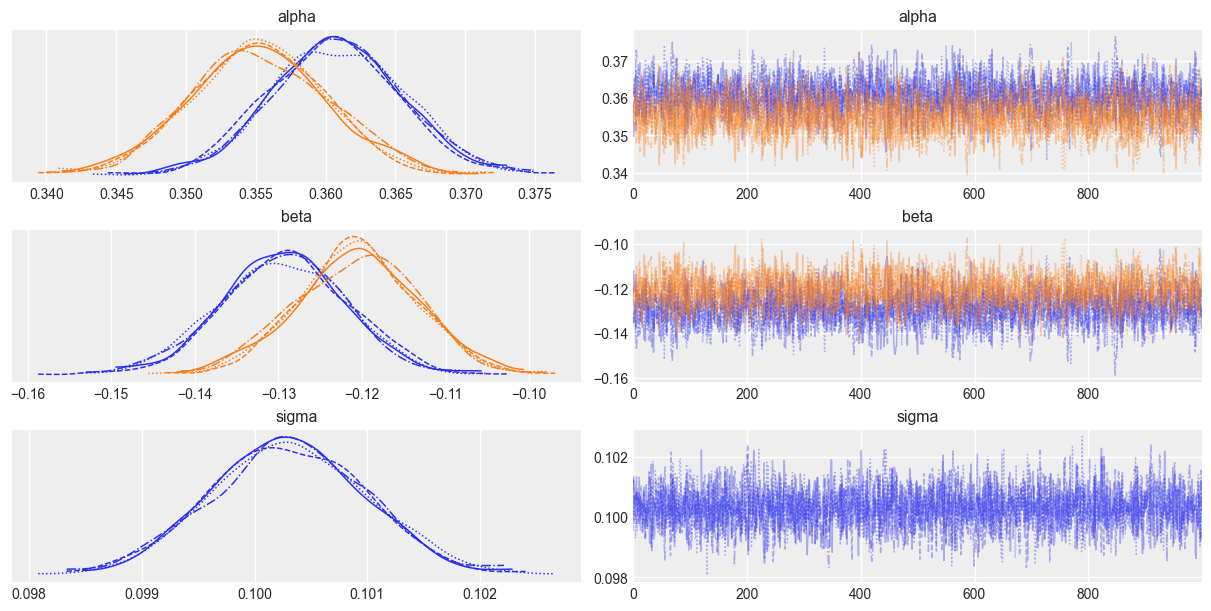

In [95]:
az.plot_trace(idata);

In [96]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],0.36,0.00,0.35,0.37,0.0,0.0,2018.99,1889.54,1.0
alpha[1],0.36,0.00,0.35,0.36,0.0,0.0,2296.79,2132.19,1.0
beta[0],-0.13,0.01,-0.14,-0.11,0.0,0.0,1998.59,1755.64,1.0
beta[1],-0.12,0.01,-0.13,-0.11,0.0,0.0,2275.34,1954.21,1.0
sigma,0.10,0.00,0.10,0.10,0.0,0.0,3096.47,2270.42,1.0


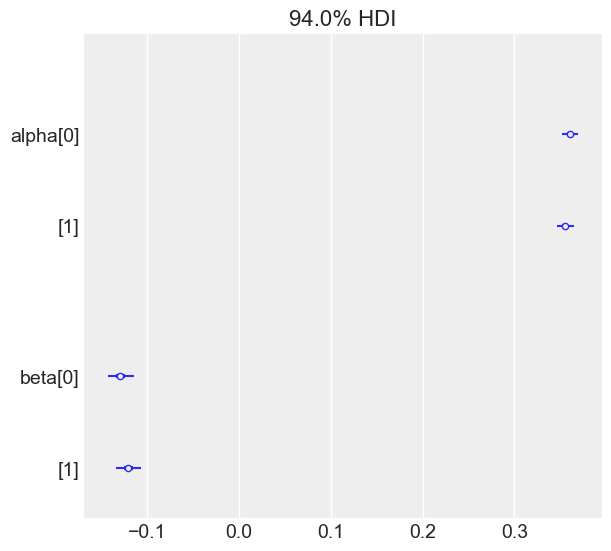

In [97]:
az.plot_forest(idata, var_names=['alpha', 'beta'], combined=True)
plt.show()

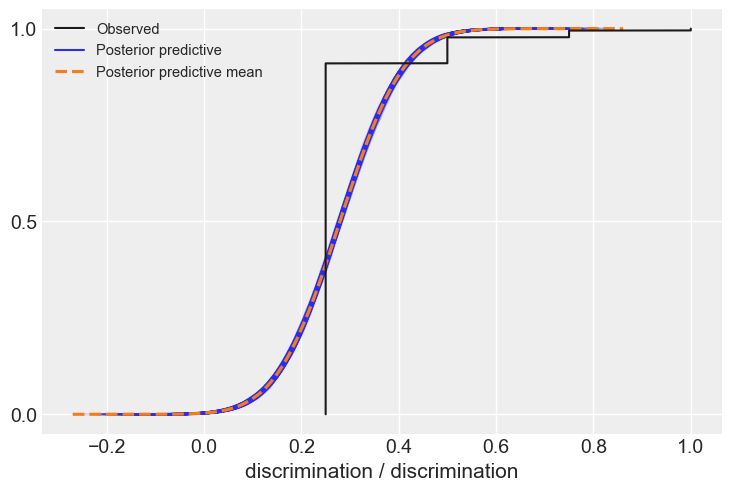

In [98]:
az.plot_ppc(idata, num_pp_samples=500, kind='cumulative')
plt.show()

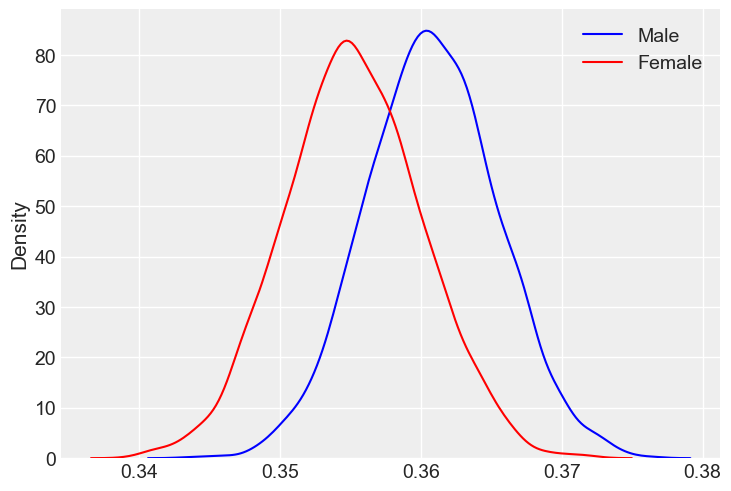

In [99]:
sns.kdeplot(np.concatenate(idata.posterior['alpha'][:, :, 0]), label='Male', color='blue')
sns.kdeplot(np.concatenate(idata.posterior['alpha'][:, :, 1]), label='Female', color='red')
plt.legend()
plt.show()

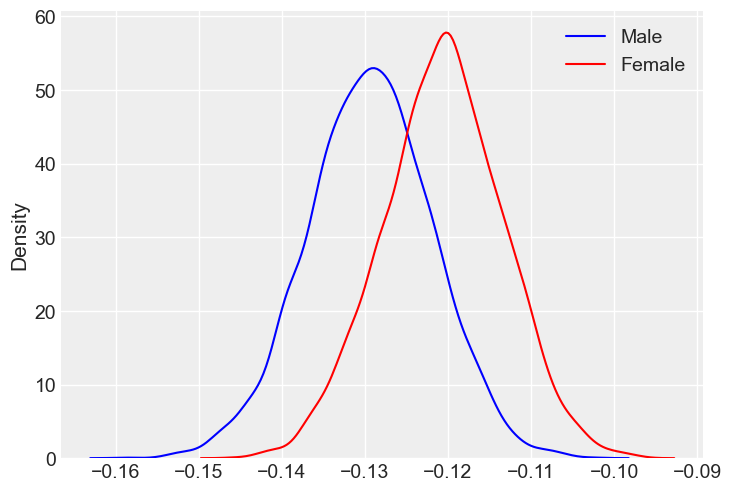

In [100]:
sns.kdeplot(np.concatenate(idata.posterior['beta'][:, :, 0]), label='Male', color='blue')
sns.kdeplot(np.concatenate(idata.posterior['beta'][:, :, 1]), label='Female', color='red')
plt.legend()
plt.show()

In [101]:
male_alpha = idata.posterior['alpha'][:, :, 0].values.reshape(-1)
male_beta = idata.posterior['beta'][:, :, 0].values.reshape(-1)

female_alpha = idata.posterior['alpha'][:, :, 1].values.reshape(-1)
female_beta = idata.posterior['beta'][:, :, 1].values.reshape(-1)

sigma_samples = idata.posterior['sigma'].values.reshape(4000, 1)

In [102]:
age_range = np.arange(data.age.min(), data.age.max()+1, 1)/data.age.max()

In [103]:
disc_male = np.random.normal((male_alpha + age_range[:, None]*male_beta).T, sigma_samples)
disc_female = np.random.normal((female_alpha + age_range[:, None]*female_beta).T, sigma_samples)

/Users/ipeletier/Personal/articles/.venv/lib/python3.9/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/ipeletier/Personal/articles/.venv/lib/python3.9/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


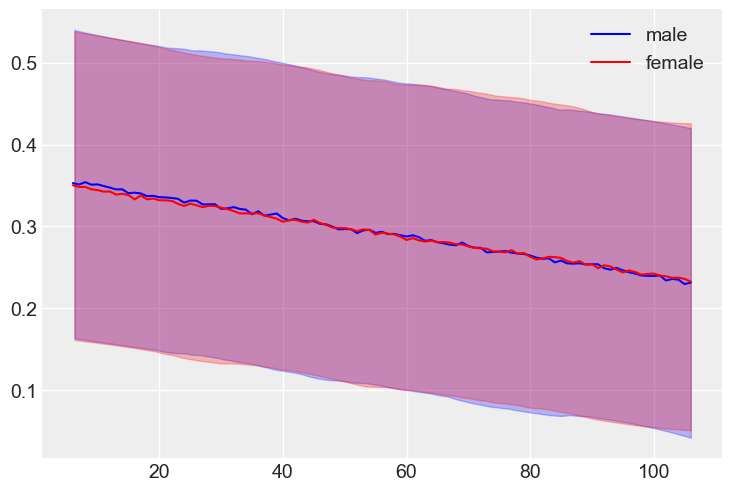

In [104]:
az.plot_hdi(age_range*data.age.max(), disc_male, color='blue', fill_kwargs={'alpha': 0.25})
az.plot_hdi(age_range*data.age.max(), disc_female, color='red', fill_kwargs={'alpha': 0.25})
plt.plot(age_range*data.age.max(), disc_male.mean(axis=0), color='blue', label='male')
plt.plot(age_range*data.age.max(), disc_female.mean(axis=0), color='red', label='female')
plt.legend()
plt.show()

/Users/ipeletier/Personal/articles/.venv/lib/python3.9/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/ipeletier/Personal/articles/.venv/lib/python3.9/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


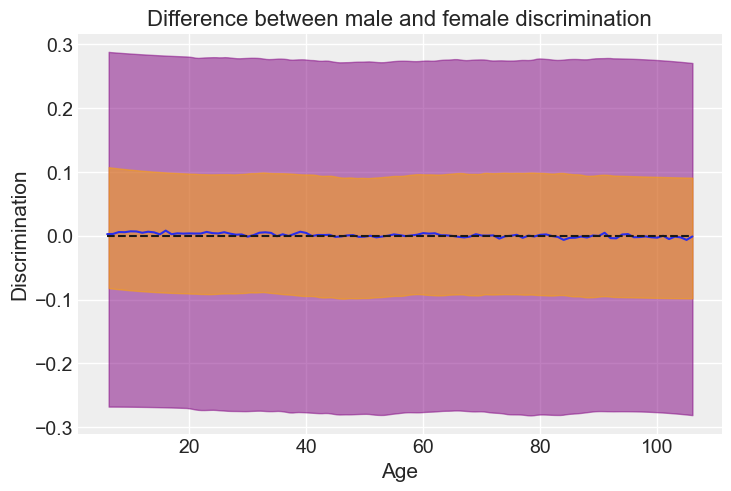

In [105]:
az.plot_hdi(age_range*data.age.max(), disc_male - disc_female, color='purple', hdi_prob=0.95)
az.plot_hdi(age_range*data.age.max(), disc_male - disc_female, color='orange', hdi_prob=0.50)
plt.plot(age_range*data.age.max(),(disc_male - disc_female).mean(axis=0))
plt.title('Difference between male and female discrimination')
plt.ylabel('Discrimination')
plt.xlabel('Age')
plt.hlines(xmin=data.age.min(), xmax=data.age.max(), y=0, color='k', linestyles='--')
plt.show()

### Spline Regression, Gaussian Likelihood

In [153]:
num_knots = 4
knot_list = np.linspace(0, 110, num_knots+2)[1:-1]

In [154]:
B = dmatrix(
    'bs(age, knots=knots, degree=3, include_intercept=True) - 1',
    {'age': data.age.sort_values(), 'knots': knot_list},
)

In [155]:
COORDS = {"splines": np.arange(B.shape[1]), "sex": [0, 1]}
with pm.Model(coords=COORDS) as spline_model:
    # Separate spline coefficients for each sex
    w_0 = pm.Normal("w_0", mu=0, sigma=1, size=B.shape[1], dims="splines")
    w_1 = pm.Normal("w_1", mu=0, sigma=1, size=B.shape[1], dims="splines")

    # Conditional structure for applying spline coefficients
    mu_0 = pm.Deterministic("mu_0", pm.math.dot(np.asarray(B, order="F"), w_0.T))
    mu_1 = pm.Deterministic("mu_1", pm.math.dot(np.asarray(B, order="F"), w_1.T))
    mu = pm.math.switch(pm.math.eq(data.sex, 0), mu_0, mu_1)

    # Rest of the model remains the same
    sigma = pm.Exponential("sigma", 1)
    D = pm.Normal("D", mu=mu, sigma=sigma, observed=data.discrimination_n)

    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(draws=1000, tune=1000, random_seed=RANDOM_SEED, chains=4))
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

    # Posterior analysis
    # Here you can compute the contrasts between w_0 and w_1 posteriors

Sampling: [D, sigma, w_0, w_1]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w_0, w_1, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
Sampling: [D]


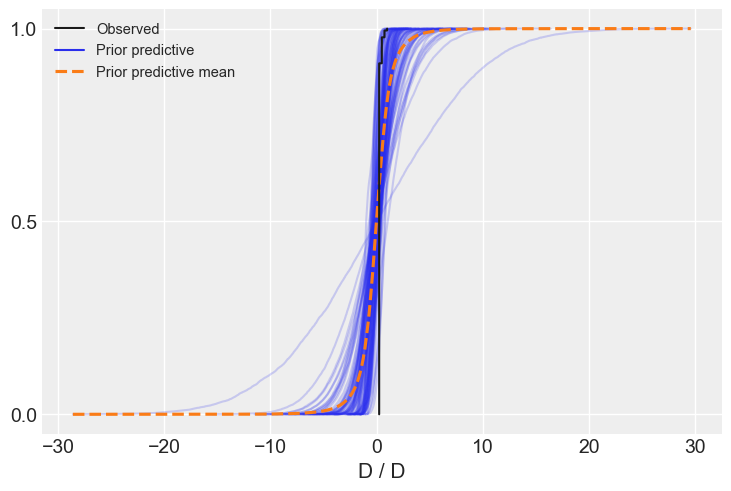

In [156]:
az.plot_ppc(idata, group='prior', num_pp_samples=100, kind='cumulative')
plt.show()

In [157]:
az.summary(idata, var_names=["w_0", "w_1","sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w_0[0],0.318,0.017,0.289,0.350,0.000,0.000,4253.0,3194.0,1.0
w_0[1],0.352,0.016,0.322,0.382,0.000,0.000,3653.0,3072.0,1.0
w_0[2],0.338,0.016,0.309,0.367,0.000,0.000,3248.0,2940.0,1.0
w_0[3],0.331,0.009,0.313,0.348,0.000,0.000,2810.0,2713.0,1.0
w_0[4],0.255,0.008,0.240,0.271,0.000,0.000,2612.0,2809.0,1.0
w_0[5],0.270,0.011,0.248,0.291,0.000,0.000,2717.0,2799.0,1.0
w_0[6],0.244,0.022,0.204,0.287,0.000,0.000,3007.0,2896.0,1.0
w_0[7],0.381,0.191,0.030,0.753,0.003,0.002,3906.0,3138.0,1.0
w_1[0],0.296,0.023,0.252,0.341,0.000,0.000,5133.0,3602.0,1.0
w_1[1],0.307,0.019,0.269,0.342,0.000,0.000,3808.0,2992.0,1.0


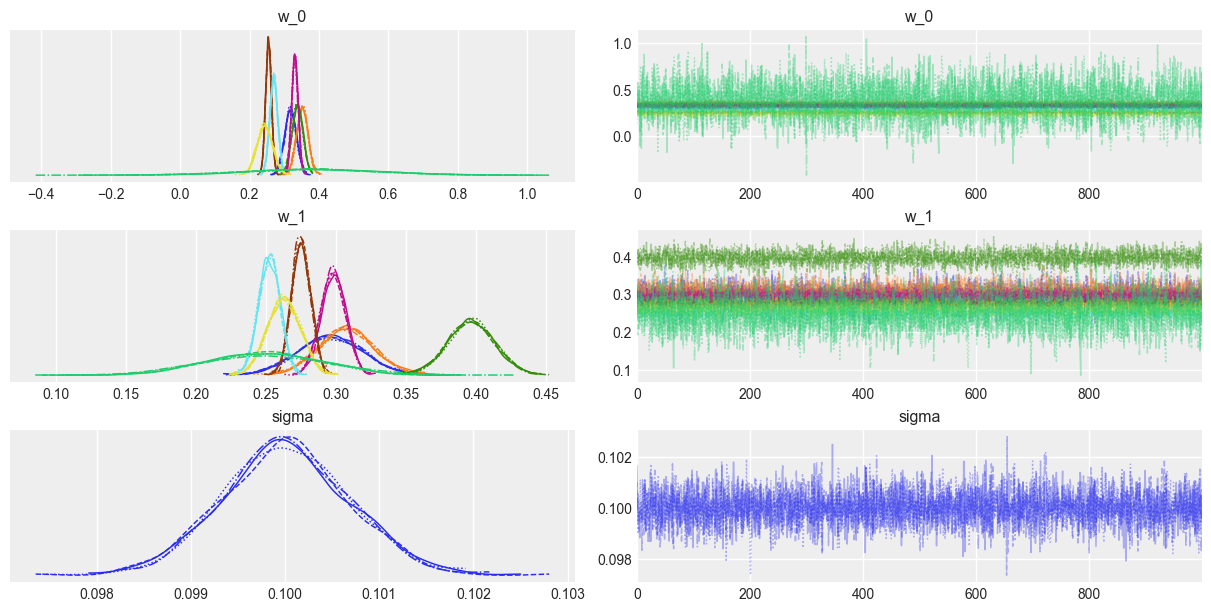

In [158]:
az.plot_trace(idata, var_names=["w_0", "w_1", "sigma"]);

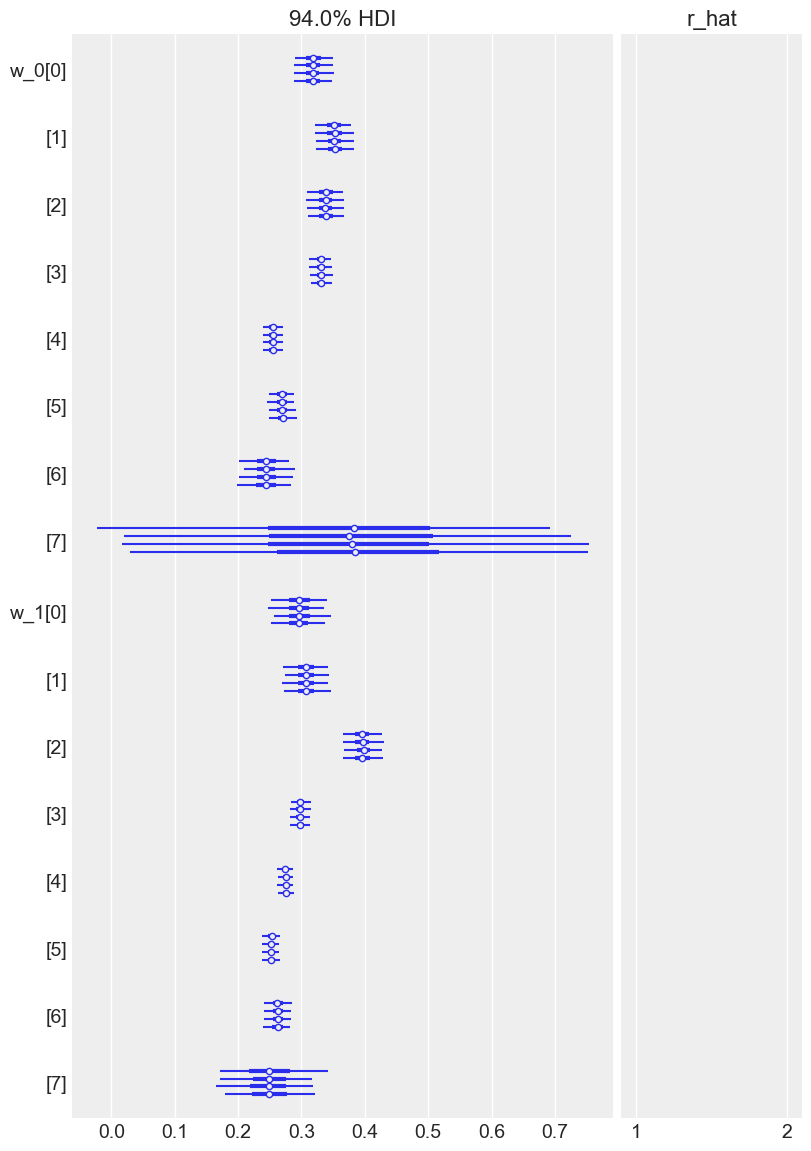

In [159]:
az.plot_forest(idata, var_names=["w_0", "w_1"], combined=False, r_hat=True);

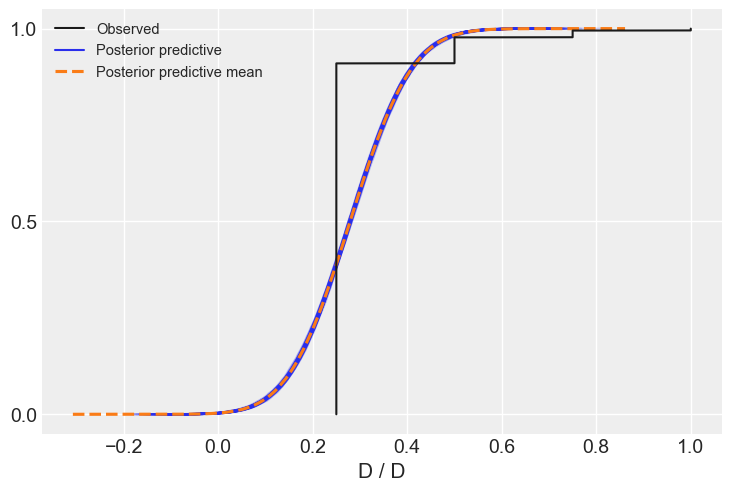

In [160]:
az.plot_ppc(idata, num_pp_samples=100, kind='cumulative')
plt.show()

In [161]:
# Create age grid and basis matrix for the age grid
age_grid = np.linspace(data.age.min(), data.age.max(), 100)
B_grid = dmatrix(
    'bs(age, knots=knots, degree=3, include_intercept=True) - 1',
    {'age': age_grid, 'knots': knot_list},
)

n_samples = 4000


with spline_model:
    
    w_0_samples = idata.posterior['w_0'].values
    w_1_samples = idata.posterior['w_1'].values
    sigma_samples = idata.posterior['sigma'].values

    # Predictions for each sex across the age grid
    mu_0 = np.dot(B_grid, w_0_samples.reshape(-1, B_grid.shape[1]).T)
    mu_1 = np.dot(B_grid, w_1_samples.reshape(-1, B_grid.shape[1]).T)

    # Ensure the shapes are compatible
    mu_0 = mu_0.T  # Shape: (n_samples, len(age_grid))
    mu_1 = mu_1.T  # Shape: (n_samples, len(age_grid))
    
    # Draw samples from the Gaussian likelihood
    ppd_male = np.random.normal(mu_0, sigma_samples.reshape(n_samples, 1))
    ppd_female = np.random.normal(mu_1, sigma_samples.reshape(n_samples, 1))

# Calculate contrasts
contrasts = (ppd_male - ppd_female)  

hdi_95 = az.hdi(contrasts, hdi_prob=0.95)
hdi_50 = az.hdi(contrasts, hdi_prob=0.50)

# Calculate mean contrast
mean_contrast = contrasts.mean(axis=0)

/var/folders/5l/01f91zmj7mq1k2wrl_k7z2740000gn/T/ipykernel_11704/3033917263.py:32: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_95 = az.hdi(contrasts, hdi_prob=0.95)
/var/folders/5l/01f91zmj7mq1k2wrl_k7z2740000gn/T/ipykernel_11704/3033917263.py:33: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_50 = az.hdi(contrasts, hdi_prob=0.50)


/Users/ipeletier/Personal/articles/.venv/lib/python3.9/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/ipeletier/Personal/articles/.venv/lib/python3.9/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


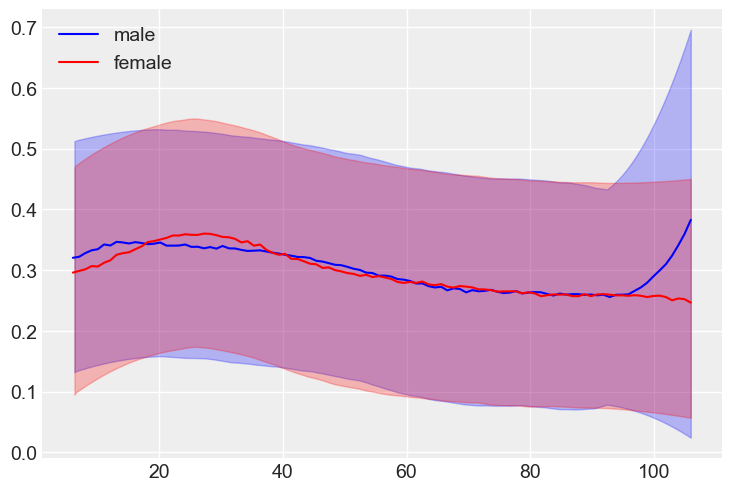

In [164]:
az.plot_hdi(age_grid, ppd_male, color='blue', fill_kwargs={'alpha': 0.25})
az.plot_hdi(age_grid, ppd_female, color='red', fill_kwargs={'alpha': 0.25})
plt.plot(age_grid, ppd_male.mean(axis=0), color='blue', label='male')
plt.plot(age_grid, ppd_female.mean(axis=0), color='red', label='female')
plt.legend()
plt.show()

/Users/ipeletier/Personal/articles/.venv/lib/python3.9/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/Users/ipeletier/Personal/articles/.venv/lib/python3.9/site-packages/arviz/plots/hdiplot.py:156: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


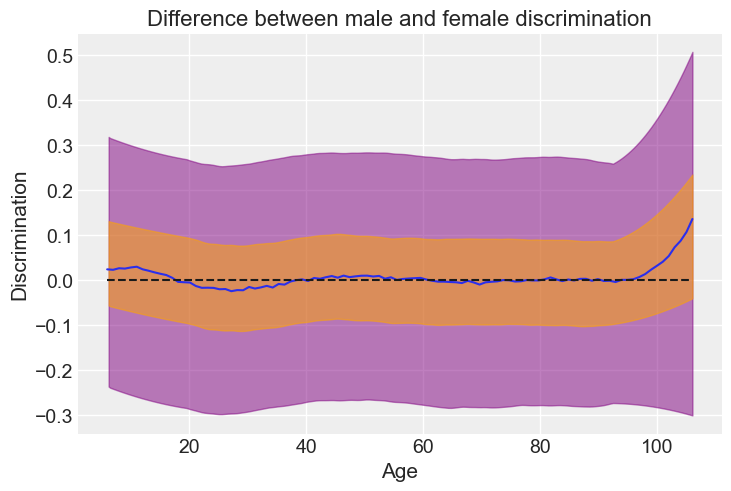

In [163]:
az.plot_hdi(age_grid, contrasts, color='purple', hdi_prob=0.95)
az.plot_hdi(age_grid, contrasts, color='orange', hdi_prob=0.5)
plt.plot(age_grid,contrasts.mean(axis=0))
plt.title('Difference between male and female discrimination')
plt.ylabel('Discrimination')
plt.xlabel('Age')
plt.hlines(xmin=data.age.min(), xmax=data.age.max(), y=0, color='k', linestyles='--')
plt.show()

### Spline Regression, Ordinal Likelihood

In [170]:
COORDS = {"splines": np.arange(B.shape[1]), "sex": [0, 1]}
with pm.Model(coords=COORDS) as ordinal_model:
    # Separate spline coefficients for each sex
    w_0 = pm.Normal("w_0", mu=0, sigma=1, size=B.shape[1], dims="splines")
    w_1 = pm.Normal("w_1", mu=0, sigma=1, size=B.shape[1], dims="splines")

    # Conditional structure for applying spline coefficients
    mu_0 = pm.math.dot(np.asarray(B, order="F"), w_0.T)
    mu_1 = pm.math.dot(np.asarray(B, order="F"), w_1.T)
    mu = pm.math.switch(pm.math.eq(data.sex, 0), mu_0, mu_1)

    # Cutpoints for the ordinal regression
    cutpoint_offsets = pm.HalfNormal("cutpoint_offsets", sigma=1.5, shape=3)
    cutpoints = pm.Deterministic("cutpoints", pm.math.cumsum(cutpoint_offsets) - 1.5)

    # Ordinal regression model
    D = pm.OrderedLogistic("D", mu=mu, cutpoints=cutpoints, observed=data.discrimination_n)

    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(draws=1000, tune=1000, random_seed=RANDOM_SEED, chains=4))
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)

AttributeError: module 'pymc.math' has no attribute 'cumsum'

In [168]:
import theano.tensor as tt

ModuleNotFoundError: No module named 'theano'

In [173]:
data = pd.DataFrame({
    'age': np.random.randint(20, 60, size=100),
    'sex': np.random.randint(0, 2, size=100),
    'outcome': np.random.randint(1, 5, size=100)  # Ordinal outcome from 1 to 4
})

B = dmatrix("bs(data.age, df=5, degree=3)", {"data.age": data.age})

COORDS = {"splines": np.arange(B.shape[1]), "sex": [0, 1]}
with pm.Model(coords=COORDS) as ordinal_model:
    # Spline coefficients
    spline_coefs = pm.Normal("spline_coefs", mu=0, sigma=1, size=B.shape[1], dims="splines")

    # Sex coefficient
    sex_coef = pm.Normal("sex_coef", mu=0, sigma=1)

    # Linear predictor
    eta = pm.math.dot(B, spline_coefs) + sex_coef * data.sex

    # Cutpoints for the ordinal regression
    cutpoints = pm.Normal("cutpoints", mu=0, sigma=1.5, size=3, 
                          transform=pm.distributions.transforms.ordered)

    # Ordinal regression model
    outcome = pm.OrderedLogistic("outcome", eta=eta, cutpoints=cutpoints, observed=data.outcome)

    # Sampling
    trace = pm.sample(1000, tune=1000)

AttributeError: module 'pymc.distributions.transforms' has no attribute 'ordered'